In [1]:
import sys
sys.path.insert(1, 'C:/Users/raena/Documents/Imperial College London/msc_thesis/code/functions_and_classes')

from dataRead import *
from glob import glob
import pandas as pd
import numpy as np

## Check EQW over whole period

In [2]:
# Get DJI Index weights data per quarter

DJI_weights_paths = glob('../../data/dataBBG/DJI_index_weights/DJI_*.pickle')
DJI_weights_per_quarter = {}
for path in DJI_weights_paths:
    date = path.split('.')[-2].split('_')[-1]
    DJI_weights_per_quarter[date] = pd.read_pickle(path)

# Import price and volume data for each stock in the DJI Index
DJI_PX_LAST_paths = glob('../../data/dataBBG/DJI_stock_PX_LAST/* Equity.pickle')
DJI_PX_VOLUME_paths = glob('../../data/dataBBG/DJI_stock_PX_VOLUME/* Equity.pickle')

DJI_price_data = {}
DJI_volume_data = {}

for path in DJI_PX_LAST_paths:
    ticker = (' ').join(path.split('.')[-2].split('\\')[-1].split(' ')[0:1])
    # if ticker == '3277Q UN': # JP Morgan
    #     path = '../../data/dataBBG/DJI_stock_PX_LAST/JPM UN Equity.pickle'
    df = pd.read_pickle(path).set_index('date')
    df.index = pd.to_datetime(df.index)
    DJI_price_data[ticker] = df

for path in DJI_PX_VOLUME_paths:
    ticker = (' ').join(path.split('.')[-2].split('\\')[-1].split(' ')[0:1])
    df = pd.read_pickle(path).set_index('date')
    df.index = pd.to_datetime(df.index)
    # df.index = pd.to_datetime(df.index)
    DJI_volume_data[ticker] = df

trading_days = pd.to_datetime(list(DJI_price_data['AAPL'].index))

# Heatmap


In [3]:
AUM = 1e6
qDates = list(DJI_weights_per_quarter.keys())
n_q = len(qDates)
results = {}

k = -1
# dat = qDates[k-4]
# datend = str(int(qDates[k]) - 1)
dat = '20211231'
datend = '20220214'
weights_data = DJI_weights_per_quarter[dat]
members = weights_data.sort_values(by = 'Weight', ascending = False)['INDX_MWEIGHT_HIST']
# wgt = weights_data.set_index('INDX_MWEIGHT_HIST')['Weight']
prices = pd.DataFrame({ticker: DJI_price_data[ticker]['PX_LAST'] for ticker in DJI_price_data.keys()})
volumes = pd.DataFrame({ticker: DJI_volume_data[ticker]['PX_VOLUME'] for ticker in DJI_price_data.keys()})
tempR = np.log(prices.loc[str(dat):str(datend),members]).diff(1).iloc[1:] # log returns
tempV = volumes.loc[str(dat):str(datend),members].iloc[1:] 
tempV = np.log(tempV)
tempV = (tempV - tempV.mean(axis=0))/tempV.std(axis = 0, ddof=1)
print(tempR.shape)

(30, 30)


In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

def corr_heatmap(heatmap1, 
                axislabels, 
                ax,
                title = "Sample Historical Correlation of Daily Returns",
                vmin = -1,
                vmax = 1,
                cmap = 'PiYG'):
    sns.heatmap(heatmap1, cmap = cmap, vmin = vmin, vmax = vmax, cbar=False, ax = ax)
    ax.set_xticks(np.arange(heatmap1.shape[0]) + 0.5, labels=axislabels,
                     rotation=45, ha="right", va="center", rotation_mode="anchor")
    ax.set_yticks(np.arange(heatmap1.shape[0]) + 0.5, labels=axislabels,
                     rotation=0, ha="right", va="center", rotation_mode="anchor")
    ax.set_title(title, fontsize = 14)
    # fig.tight_layout()
    return fig, ax

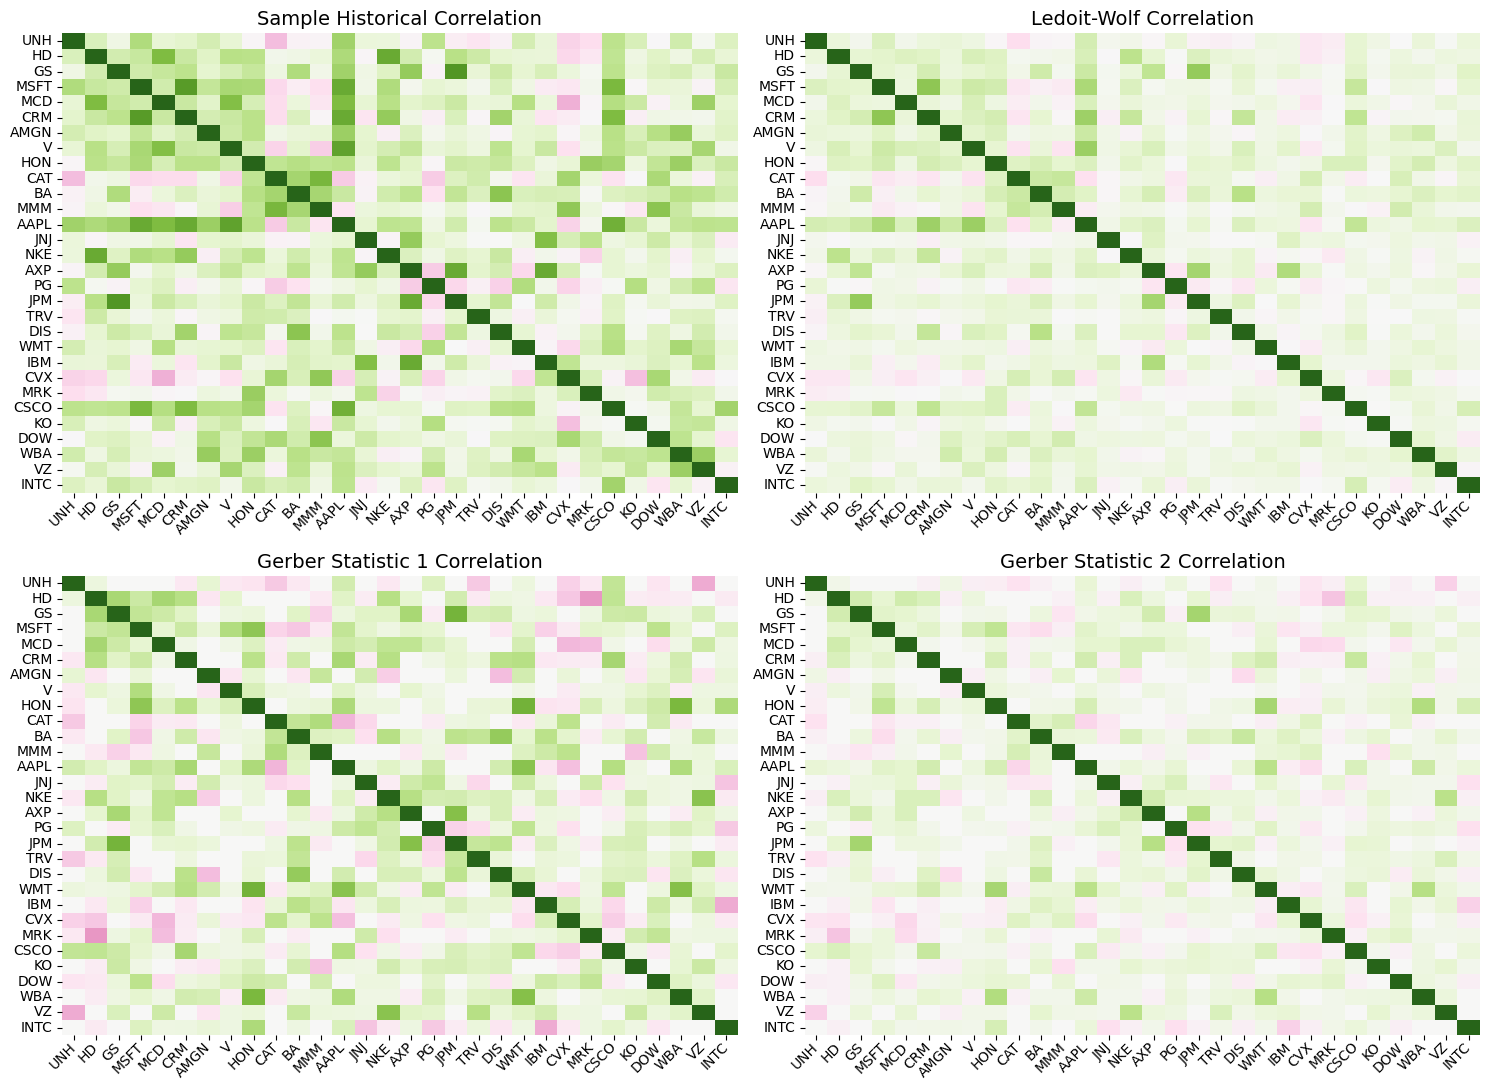

In [5]:
from covarianceMatrixVolume import *
from thresholdVectors import *
cR = 0.5
cV = 0.0

covMatInst = CovarianceMatrixVolume(returnsMatrix = tempR, volumeMatrix = tempV)
rThreshold = ThresholdVectors(tempR).standard_deviation(c = cR)
vThreshold = ThresholdVectors(tempV).standard_deviation(c = cV)

GS1 = covMatInst.GerberMatrix1(rThreshold, vThreshold, method = 'quick')[0]
GS2 = covMatInst.GerberMatrix2(rThreshold, vThreshold, method = 'quick')[0]
HIS = covMatInst.historicalCovariance()[0]
LW  = covMatInst.ledoitWolf()[0]

fpFig = '../../code/figures'
fig, ax = plt.subplots(2, 2, figsize=(15, 11))
figHIS, axHIS = corr_heatmap(HIS, axislabels = members, 
                            title = 'Sample Historical Correlation', 
                            ax = ax[0,0])
figLW , axLW  = corr_heatmap(LW , axislabels = members, 
                            title = 'Ledoit-Wolf Correlation', 
                            ax = ax[0,1])
figGS1, axGS1 = corr_heatmap(GS1, axislabels = members, 
                            title = 'Gerber Statistic 1 Correlation', 
                            ax = ax[1,0])
figGS2, axGS2 = corr_heatmap(GS2, axislabels = members, 
                            title = 'Gerber Statistic 2 Correlation', 
                            ax = ax[1,1])
fig.tight_layout()
fig.savefig(f'{fpFig}/correlation_heatmap_1.pdf', bbox_inches='tight')


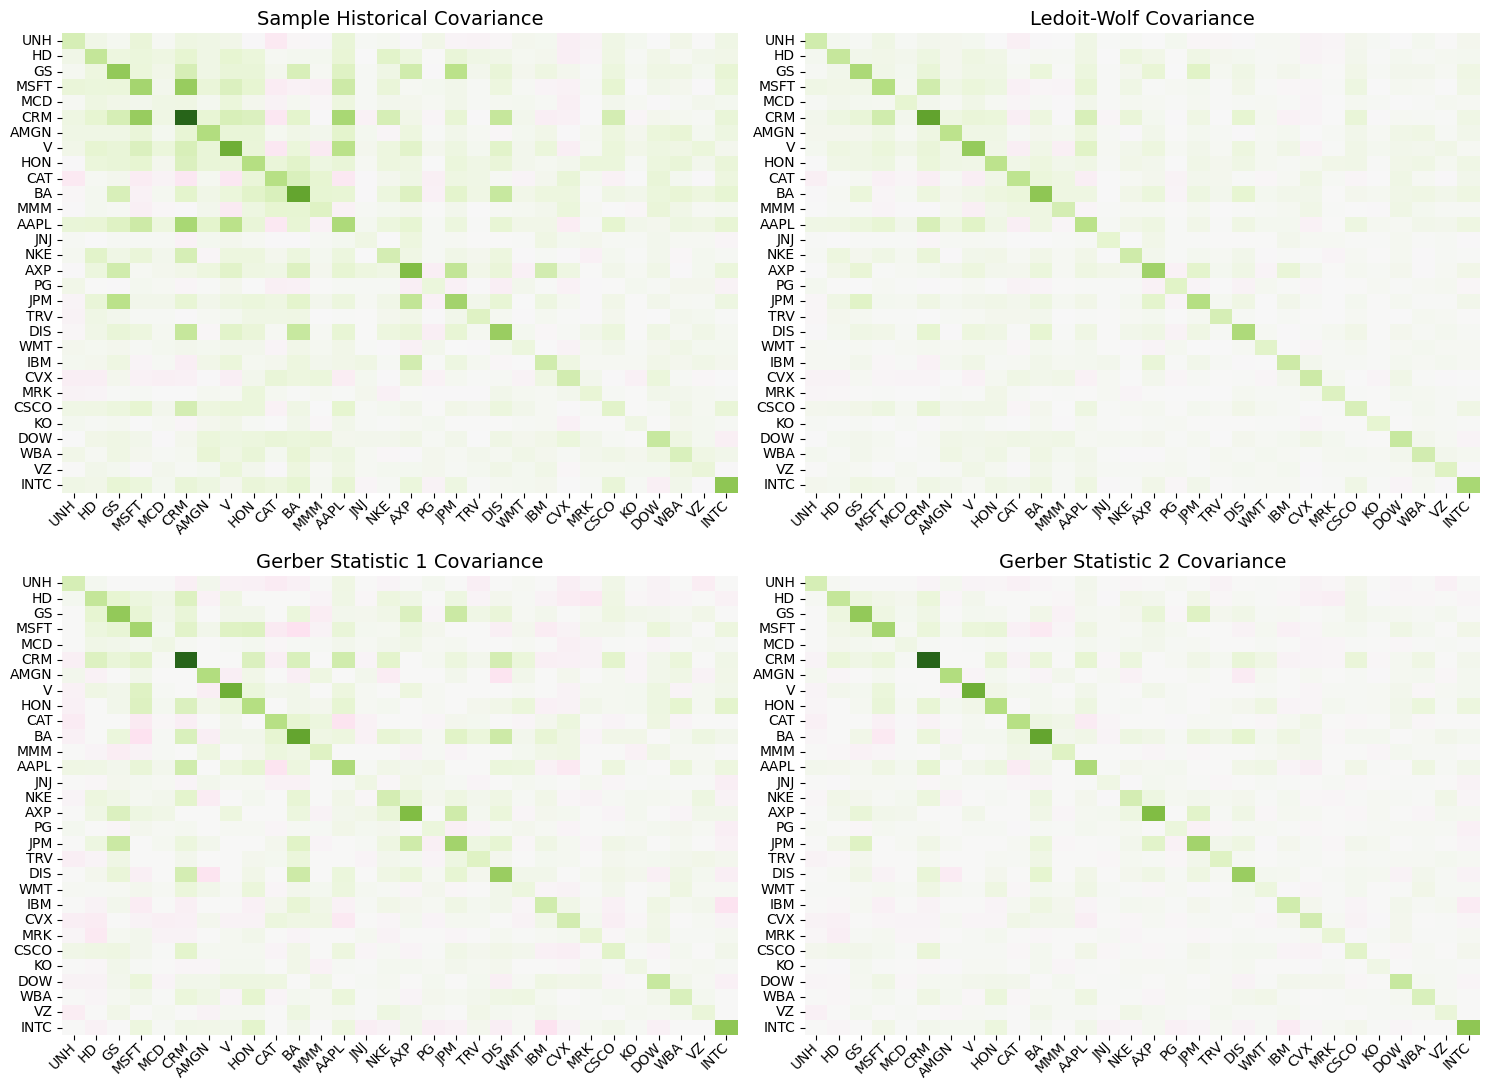

In [6]:
GS1 = covMatInst.GerberMatrix1(rThreshold, vThreshold, method = 'quick')[1]
GS2 = covMatInst.GerberMatrix2(rThreshold, vThreshold, method = 'quick')[1]
HIS = covMatInst.historicalCovariance()[1]
LW  = covMatInst.ledoitWolf()[1]
vmin = min(GS1.min(), GS2.min(), HIS.min(), LW.min())
vmax = max(GS1.max(), GS2.max(), HIS.max(), LW.max())
vmin = -1*max(abs(vmin),abs(vmax))
vmax = 1*max(abs(vmin),abs(vmax))

fpFig = '../../code/figures'
fig, ax = plt.subplots(2, 2, figsize=(15, 11))
figHIS, axHIS = corr_heatmap(HIS, axislabels = members, 
                            title = 'Sample Historical Covariance', 
                            vmin = vmin, vmax = vmax,
                            # cmap = 'Blues',
                            ax = ax[0,0])
figLW , axLW  = corr_heatmap(LW , axislabels = members, 
                            title = 'Ledoit-Wolf Covariance', 
                            vmin = vmin, vmax = vmax,
                            # cmap = 'Blues',
                            ax = ax[0,1])
figGS1, axGS1 = corr_heatmap(GS1, axislabels = members, 
                            title = 'Gerber Statistic 1 Covariance', 
                            vmin = vmin, vmax = vmax,
                            # cmap = 'Blues',
                            ax = ax[1,0])
figGS2, axGS2 = corr_heatmap(GS2, axislabels = members, 
                            title = 'Gerber Statistic 2 Covariance', 
                            vmin = vmin, vmax = vmax,
                            # cmap = 'Blues',
                            ax = ax[1,1])
fig.tight_layout()
fig.savefig(f'{fpFig}/covariance_heatmap_1.pdf', bbox_inches='tight')

